# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

**Цель:**
Построить модель, которая по фотографии определит приблизительный возраст человека. 

**План проекта:**
- Провести исследовательский анализ набора фотографий
- Подготовить данные к обучению
- Обучить нейронную сеть и рассчитайте её качество

**Описание данных:**
В нашем распоряжении набор фотографий людей с указанием возраста.

**Ожидаемый результат:**
Получить значение метрики MAE построенной свёрточной нейронной сети на тестовой выборке не больше 8.

## Исследовательский анализ данных

### Импорт библиотек:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import random 
from os import listdir
from PIL import Image
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, AveragePooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam

###  Загрузка данных

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')

Оценим размер выборки:

In [3]:
def general_info_data(df):
    display(df.head())
    display(df.info())

In [4]:
general_info_data(labels)

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


None

**ВЫВОД:**

Датафрейм содержит 7591 строк с информацией о возрасте, соответствующей файлам изображений в папке.
Пропусков нет. Типы данных указаны корректно.


Построим график распределения возраста в выборке:

In [5]:
labels['real_age'].describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

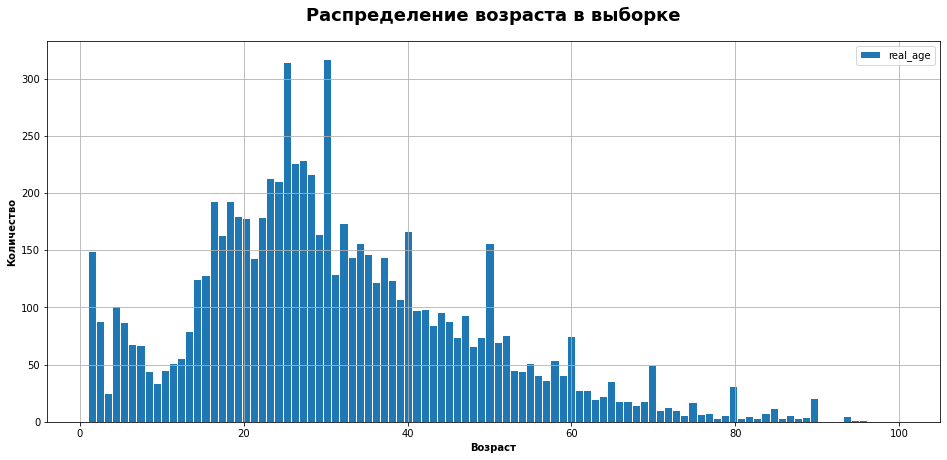

In [6]:
labels.plot(grid = True, kind = 'hist', bins=100, edgecolor = 'white', figsize = (16, 7))

plt.title('Распределение возраста в выборке',  fontsize=18, pad=20, weight='bold')
plt.xlabel('Возраст', weight='bold')
plt.ylabel('Количество', weight='bold')
plt.show()

**ВЫВОД:**

- Диапазон возрастов в датафрейме от 1  года до 100 лет;
- Данные распределены нормально, наблюдется всплеск 0-5 лет. Дальнейшие всплески с шагом в 10 лет. Возможно, при разметке часть данных, возраст указывался кратно 10ти годам.
- Наибольшее число изображений людей в возрасте 20-40 лет;
- Медианное значение возраста - 29 лет.

Выберем 15 случайных изображений, напечатаем на экране и посмотрим, как устроен датасет.

In [7]:
directory = '/datasets/faces/final_files/'

In [8]:
imagesList = os.listdir(directory)
d=random.choices(imagesList, k=15)




Файл: 002603.jpg
Возраст: 36
Размерность: (222, 222, 3)


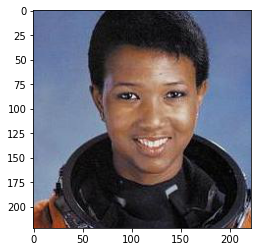




Файл: 004500.jpg
Возраст: 39
Размерность: (437, 437, 3)


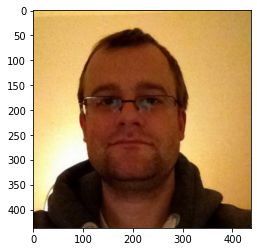




Файл: 002029.jpg
Возраст: 2
Размерность: (1132, 1132, 3)


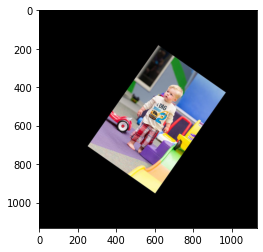




Файл: 005300.jpg
Возраст: 26
Размерность: (218, 218, 3)


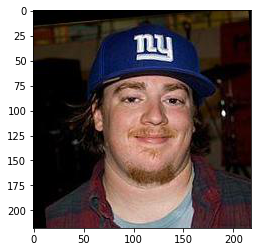




Файл: 006720.jpg
Возраст: 28
Размерность: (165, 165, 3)


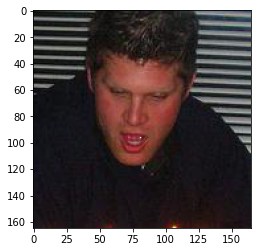




Файл: 005127.jpg
Возраст: 17
Размерность: (468, 468, 3)


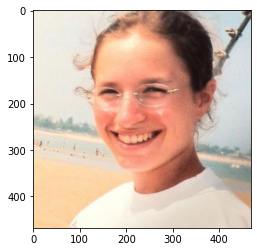




Файл: 001308.jpg
Возраст: 33
Размерность: (306, 305, 3)


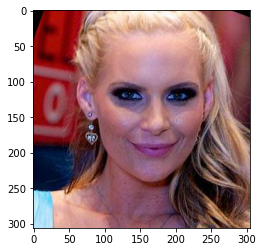




Файл: 005181.jpg
Возраст: 16
Размерность: (431, 432, 3)


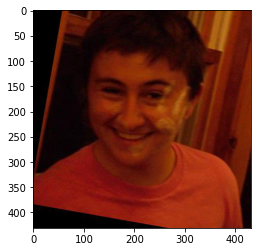




Файл: 002805.jpg
Возраст: 35
Размерность: (443, 443, 3)


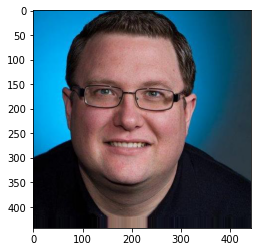




Файл: 000050.jpg
Возраст: 42
Размерность: (399, 400, 3)


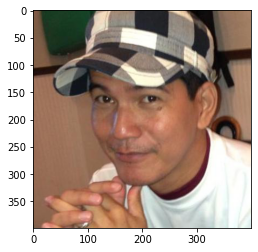




Файл: 007104.jpg
Возраст: 59
Размерность: (272, 273, 3)


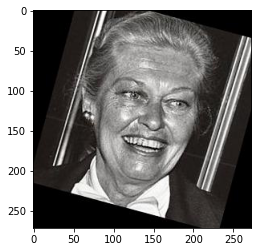




Файл: 006784.jpg
Возраст: 2
Размерность: (465, 465, 3)


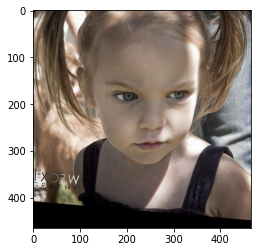




Файл: 000673.jpg
Возраст: 44
Размерность: (257, 257, 3)


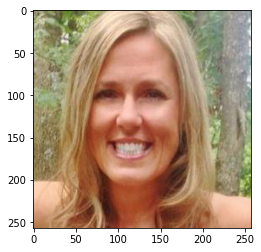




Файл: 004276.jpg
Возраст: 64
Размерность: (405, 405, 3)


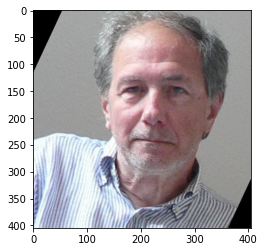




Файл: 000339.jpg
Возраст: 22
Размерность: (419, 419, 3)


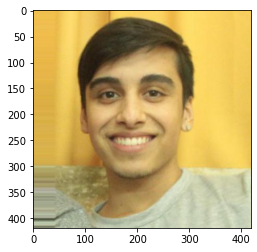

In [9]:
for i in d:
    
    file_dir = directory + str(i)
    image = Image.open(file_dir)
    array = np.array(image)
    
    print()
    print()
    print()
    print('Файл:', i)
    print('Возраст:', labels.loc[labels['file_name'] == i, 'real_age'].item())   
    print('Размерность:', array.shape) 

    plt.imshow(array, cmap='gray') 
    plt.show()

**ВЫВОД:**

- Расположение изображений в файлах вертикальное, лица крупным планом, присутствуют артефакты: чёрный или белый фон, есть «растянутые» пиксели)
- Формат файлов изображений - jpg, три цветовых канала (RGB), квадратная форма. Размерность разная.
- При подготовке тренировочных данных будем использовать аугментацию.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

def load_train(path):
    train_datagen = ImageDataGenerator(rescale=1./255)
    
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=pd.read_csv('/datasets/faces/labels.csv'),
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow


def load_test(path):
    validation_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)

    val_gen_flow = validation_datagen.flow_from_dataframe(
        dataframe=pd.read_csv('/datasets/faces/labels.csv'),
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return val_gen_flow


def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape,
                    weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', 
                    include_top=False)
        
    model = Sequential()
    optimizer = Adam(lr=0.0001)
    
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=15,
                steps_per_epoch=None, validation_steps=None):
                
    model.fit(
        train_data,
        validation_data=test_data,
        batch_size=batch_size, 
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2)
    return model


```python

Решение:

Train for 238 steps, validate for 60 steps
Epoch 1/15
2025-04-07 16:17:01.080822: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2025-04-07 16:17:01.496393: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
238/238 - 90s - loss: 223.5457 - mae: 10.6152 - val_loss: 619.9645 - val_mae: 19.8918
Epoch 2/15
238/238 - 70s - loss: 63.8336 - mae: 6.0456 - val_loss: 430.7799 - val_mae: 15.5992
Epoch 3/15
238/238 - 69s - loss: 33.1576 - mae: 4.3582 - val_loss: 128.9859 - val_mae: 8.5116
Epoch 4/15
238/238 - 70s - loss: 21.8515 - mae: 3.4919 - val_loss: 23.7993 - val_mae: 3.7510
Epoch 5/15
238/238 - 68s - loss: 17.5137 - mae: 3.1473 - val_loss: 18.7351 - val_mae: 3.2769
Epoch 6/15
238/238 - 66s - loss: 13.3992 - mae: 2.7822 - val_loss: 17.6641 - val_mae: 3.3564
Epoch 7/15
238/238 - 65s - loss: 10.5259 - mae: 2.4661 - val_loss: 15.7577 - val_mae: 3.0743
Epoch 8/15
238/238 - 65s - loss: 9.5702 - mae: 2.3297 - val_loss: 12.3460 - val_mae: 2.6010
Epoch 9/15
238/238 - 67s - loss: 7.9661 - mae: 2.1458 - val_loss: 19.9785 - val_mae: 3.6671
Epoch 10/15
238/238 - 68s - loss: 7.2386 - mae: 2.0185 - val_loss: 8.9507 - val_mae: 2.2068
Epoch 11/15
238/238 - 68s - loss: 6.5607 - mae: 1.9285 - val_loss: 9.3634 - val_mae: 2.2854
Epoch 12/15
238/238 - 66s - loss: 6.5261 - mae: 1.8989 - val_loss: 13.7036 - val_mae: 2.8516
Epoch 13/15
238/238 - 66s - loss: 5.9486 - mae: 1.8447 - val_loss: 8.7017 - val_mae: 2.2248
Epoch 14/15
238/238 - 65s - loss: 6.4814 - mae: 1.9238 - val_loss: 14.0238 - val_mae: 2.8036
Epoch 15/15
238/238 - 66s - loss: 6.3796 - mae: 1.9188 - val_loss: 7.8233 - val_mae: 2.1130
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 12s - loss: 7.8233 - mae: 2.1130

```

## Анализ обученной модели. Вывод и рекомендации.

Для сетевого супермаркета «Хлеб-Соль» построена и обучена свёрточная нейронная сеть, которая по фотографии определяет приблизительный возраст клиента.

Метрика MAE на тестовой выборке 2.1130, что удовлетворяет требованию при постановке задачи: добиться МАЕ не больше 8.


**РЕКОМЕНДАЦИИ:**

Модель рекомендовано использовать при внедрении системы компьютерного зрения для определения возраста клиентов, с целью анализа покупок и формирования предложений товаров, которые могут заинтересовать покупателей той или иной возрастной группы;

Контролировать добросовестность кассиров при продаже алкоголя с помощью полученной  модели не рекомендовано. Погрешнось в 2 года в данной задаче недопустима.